<a href="https://colab.research.google.com/github/iremarpag/Medical_Image_Analysis/blob/main/medical_image_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
PROJECT_LOCATION = "/content/drive/MyDrive/playground/medical_image_analysis/Homework1"
os.chdir(PROJECT_LOCATION)

In [ ]:
DATA_LOCATION = "./data/"

In [ ]:
import numpy as np
from numpy.random import default_rng
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import io
from skimage import color
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage

In [ ]:
# TODO: find boundaries
WHITE_LIMIT = 160
def ObtainForegroundMask(image):
  blur = cv.blur(image, (3,3))
  gray_blur = color.rgb2gray(blur) # type is float64
  gray_blur = (gray_blur*255).astype('uint8') # type is uint8
  
  # process on gray blur
  th, im_th = cv.threshold(gray_blur, WHITE_LIMIT, 255, cv.THRESH_BINARY)
  
  kernel_erode = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
  im_th = cv.erode(im_th, kernel_erode, iterations=3)


  im_floodfill = im_th.copy()
  h, w = im_th.shape
  mask = np.zeros((h+2, w+2), np.uint8)
  
  cv.floodFill(im_floodfill, mask, (0,0), 255)
  

  im_floodfill_inv = cv.bitwise_not(im_floodfill)
  im_out = im_th | im_floodfill_inv

  kernel_dilate = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
  im_out = cv.dilate(im_out, kernel_dilate, iterations = 2)
  
  kernel_close = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
  im_out = cv.morphologyEx(im_out, cv.MORPH_CLOSE, kernel_close)

  
  

  gray_blur_3d = color.gray2rgb(im_out)
  final_frame = cv.hconcat((image, gray_blur_3d))
  cv2_imshow(final_frame)
  im_out[im_out == 255] = 1
  return im_out

In [ ]:
from skimage.util import img_as_ubyte, img_as_float32

# TODO: find cells using mask
def FindCellLocations(image, mask):
  DDEPTH = cv.CV_16S
  L_KERNEL_SIZE = 3
  masked_image = cv.bitwise_and(image, image, mask=mask)
  blur = cv.GaussianBlur(masked_image, (11,11), 0)
  blur_gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
  LoG_blur = cv.Laplacian(blur_gray, DDEPTH, ksize=L_KERNEL_SIZE)
  LoG_blur = LoG_blur.astype('uint8')

  cv2_imshow(LoG_blur)

  _, th = cv.threshold(LoG_blur, 2, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
  dist = cv.distanceTransform(th, cv.DIST_L2, 3)
  
  cv.normalize(dist, dist, 0.0, 1.0, cv.NORM_MINMAX)

  
  

  _, dist = cv.threshold(dist, 0.32, 1, cv.THRESH_BINARY)
  dist = cv.dilate(dist, np.ones((5,5), dtype=np.uint8))
  #dist = cv.morphologyEx(dist, cv.MORPH_CLOSE, np.ones((5,5), dtype=np.uint8))

  #dist_8u = img_as_ubyte(dist)
  #dist_8u = cv.bitwise_and(dist_8u, dist_8u, mask = mask)

  #cv2_imshow(dist_8u)

  #dist = img_as_float32(dist_8u)
  
  dist_8u = dist.astype('uint8')


  contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  x = [0] * len(contours)
  y = [0] * len(contours)

  for i, contour in enumerate(contours):
    M = cv.moments(contour)
    x[i] = int(M['m10']/M['m00'])
    y[i] = int(M['m01']/M['m00'])
  
  markers = np.zeros(dist.shape, dtype=np.int32)
  for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)
  
  markers_8u = (markers * 10).astype('uint8')
  cv2_imshow(markers_8u)

  return x, y

In [ ]:
def FindCellBoundaries(image, mask, cells):
  return None

In [ ]:
def ShowForegroundMask(cell_file, mask_file):
  cell = cv.imread(cell_file)
  mask = np.loadtxt(mask_file, dtype='uint8')
  mask[mask == 1] = 255
  mask = color.gray2rgb(mask)
  final_frame = cv.hconcat((cell, mask))
  cv2_imshow(final_frame)

In [ ]:
def ShowCellBoundaries(cell_file, color_file):
  cell = cv.imread(cell_file)
  color_map = np.loadtxt(color_file, dtype='uint8')
  uniques = np.unique(color_map)
  unique_size = uniques.size
  rng = default_rng()
  vals = rng.integers(low=0, high=256, size=(unique_size, 3))
  vals[0] = np.array([0,0,0])


  color_3d_map = color.gray2rgb(color_map)
  for i in np.nditer(uniques):
    color_3d_map[color_map == i] = vals[i]


  final_frame = cv.hconcat((cell, color_3d_map))
  cv2_imshow(final_frame)

In [ ]:
cell_file = DATA_LOCATION + "im1.jpg"
cell_mask_file = DATA_LOCATION + "im1_gold_mask.txt"
cell_color_file = DATA_LOCATION + "im1_gold_cells.txt"

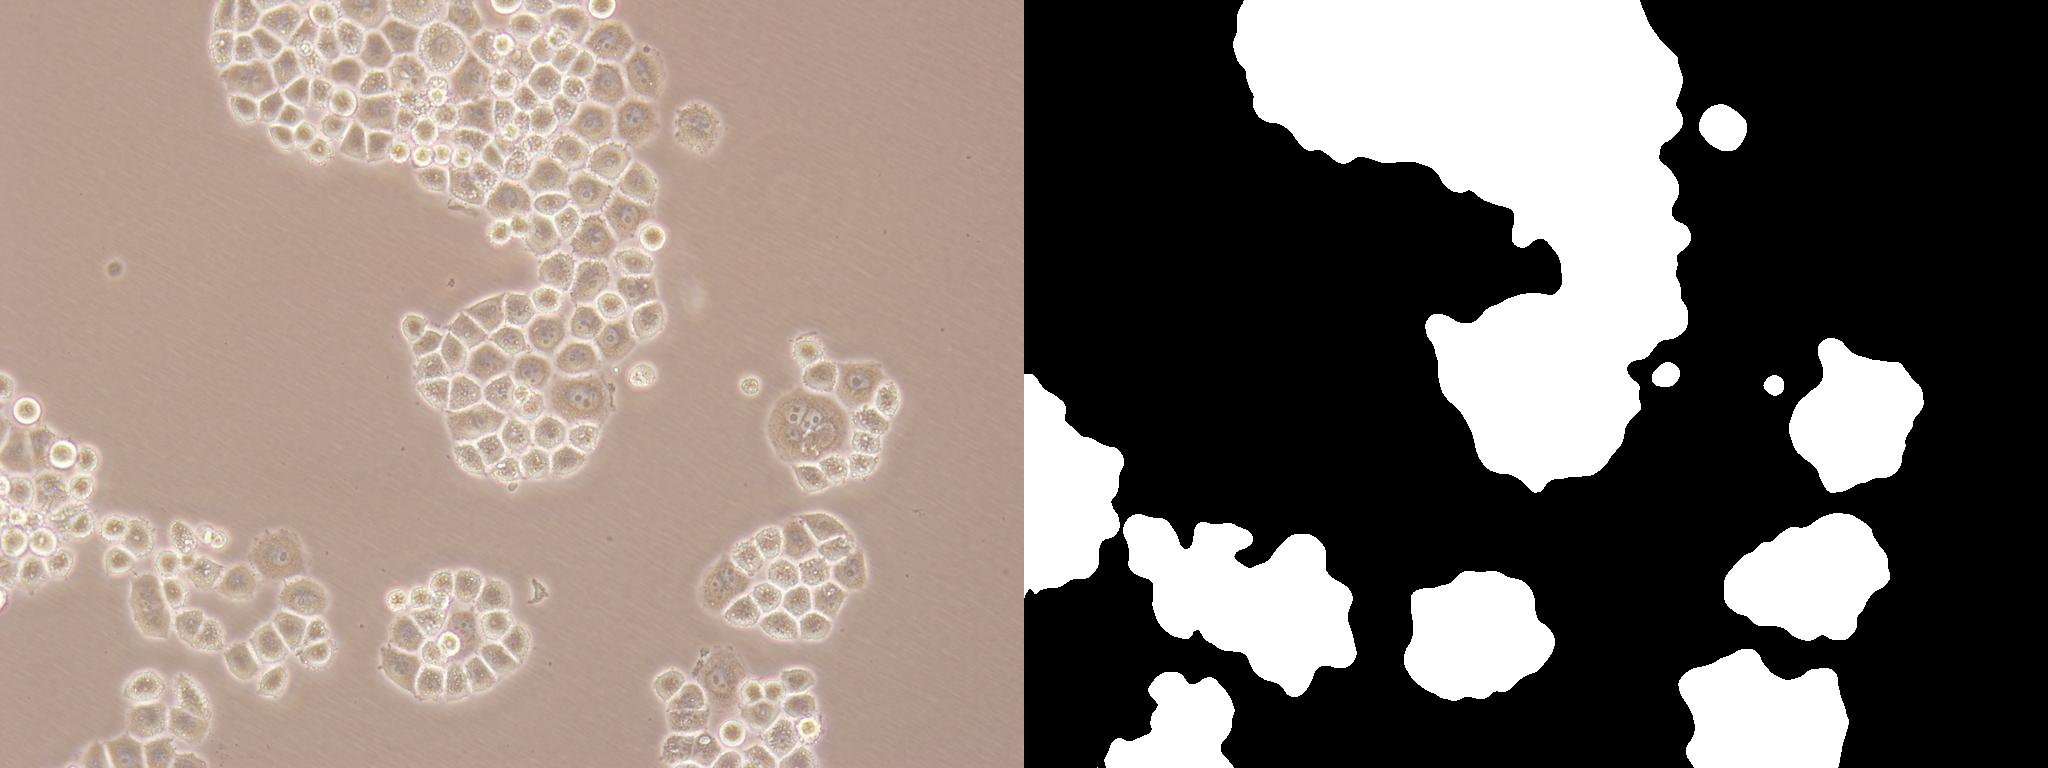

In [ ]:
ShowForegroundMask(cell_file, cell_mask_file)

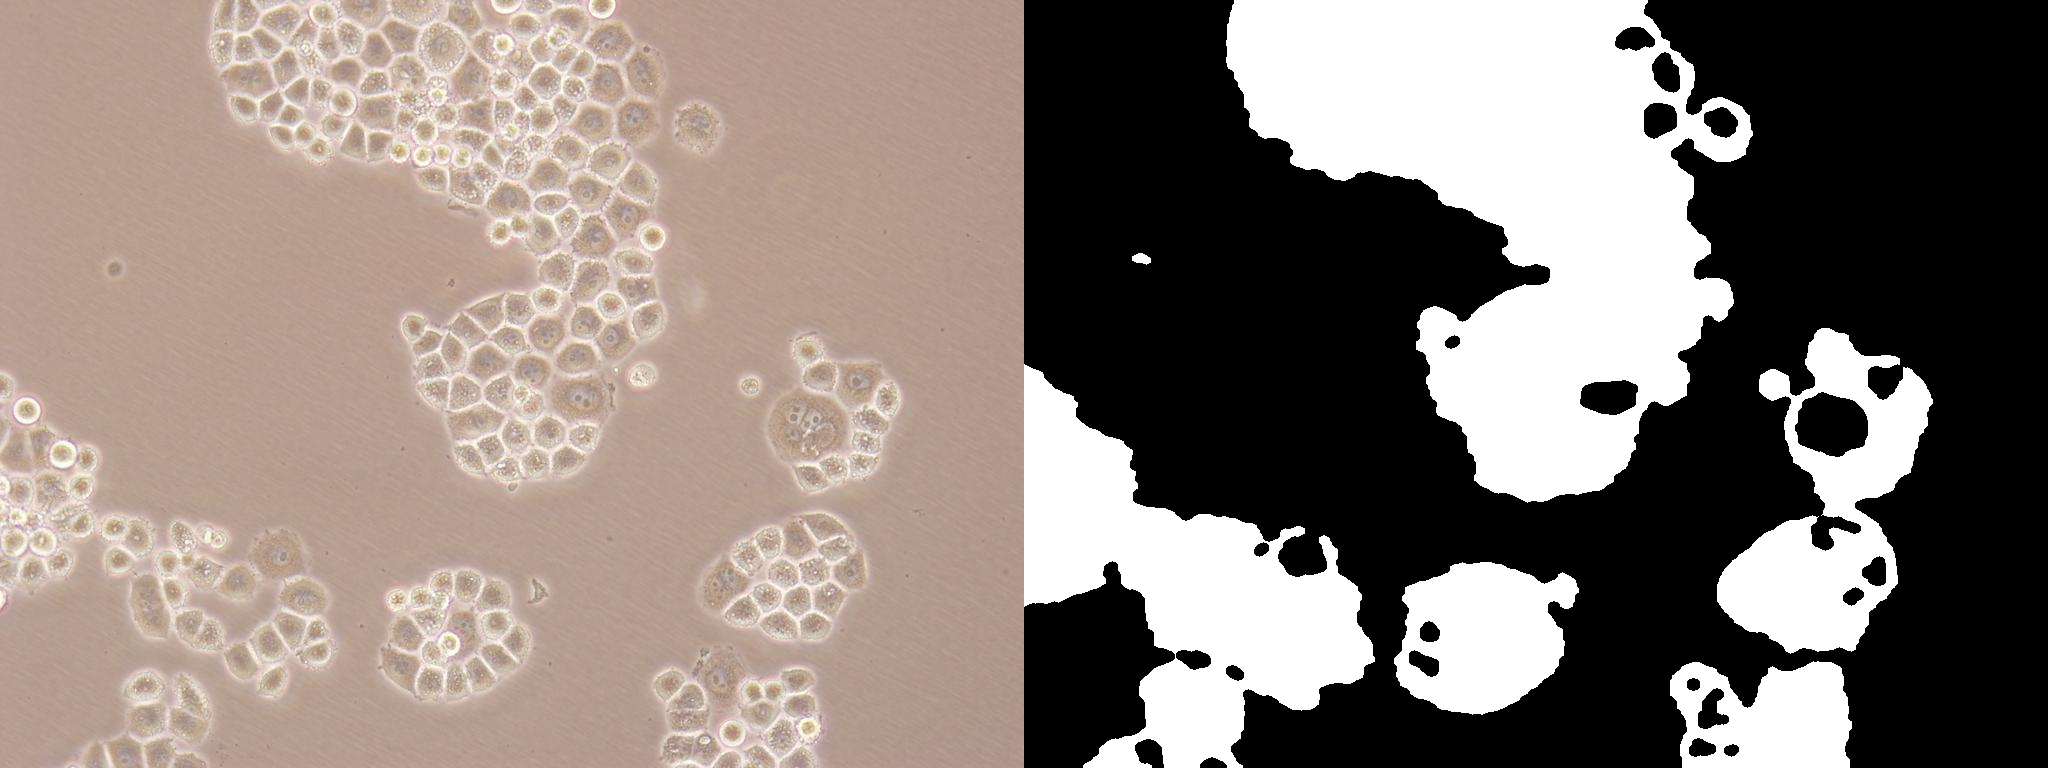

In [ ]:
cell_image = cv.imread(cell_file)
foreground_mask = ObtainForegroundMask(cell_image)


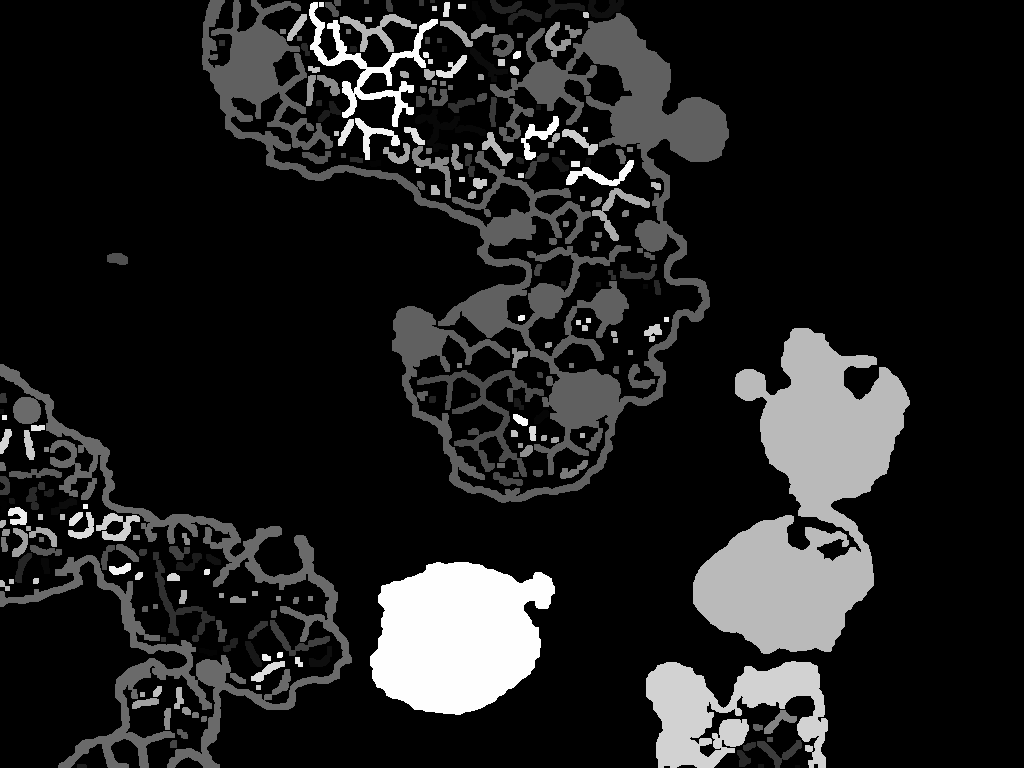

In [ ]:
x, y = FindCellLocations(cell_image, foreground_mask)